In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/isipd/projects/p_FLOCHAR/_expeditions/2024/Summer/_data/Trios/Trios/FLOCHAR_2024_Rrs_filelist_Stations61_70_AM.csv')

No stable period found. Forcing selection of the median time index.


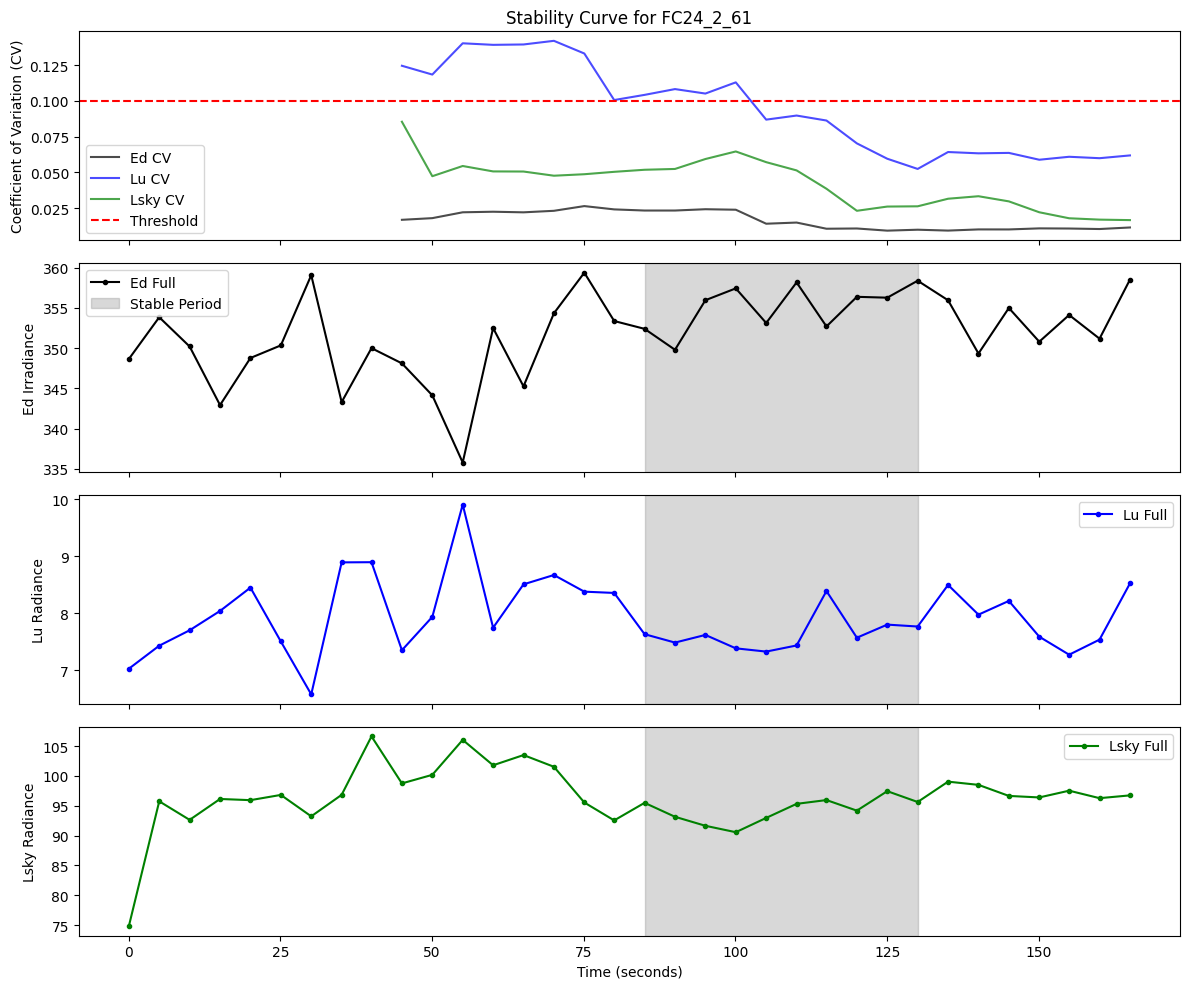

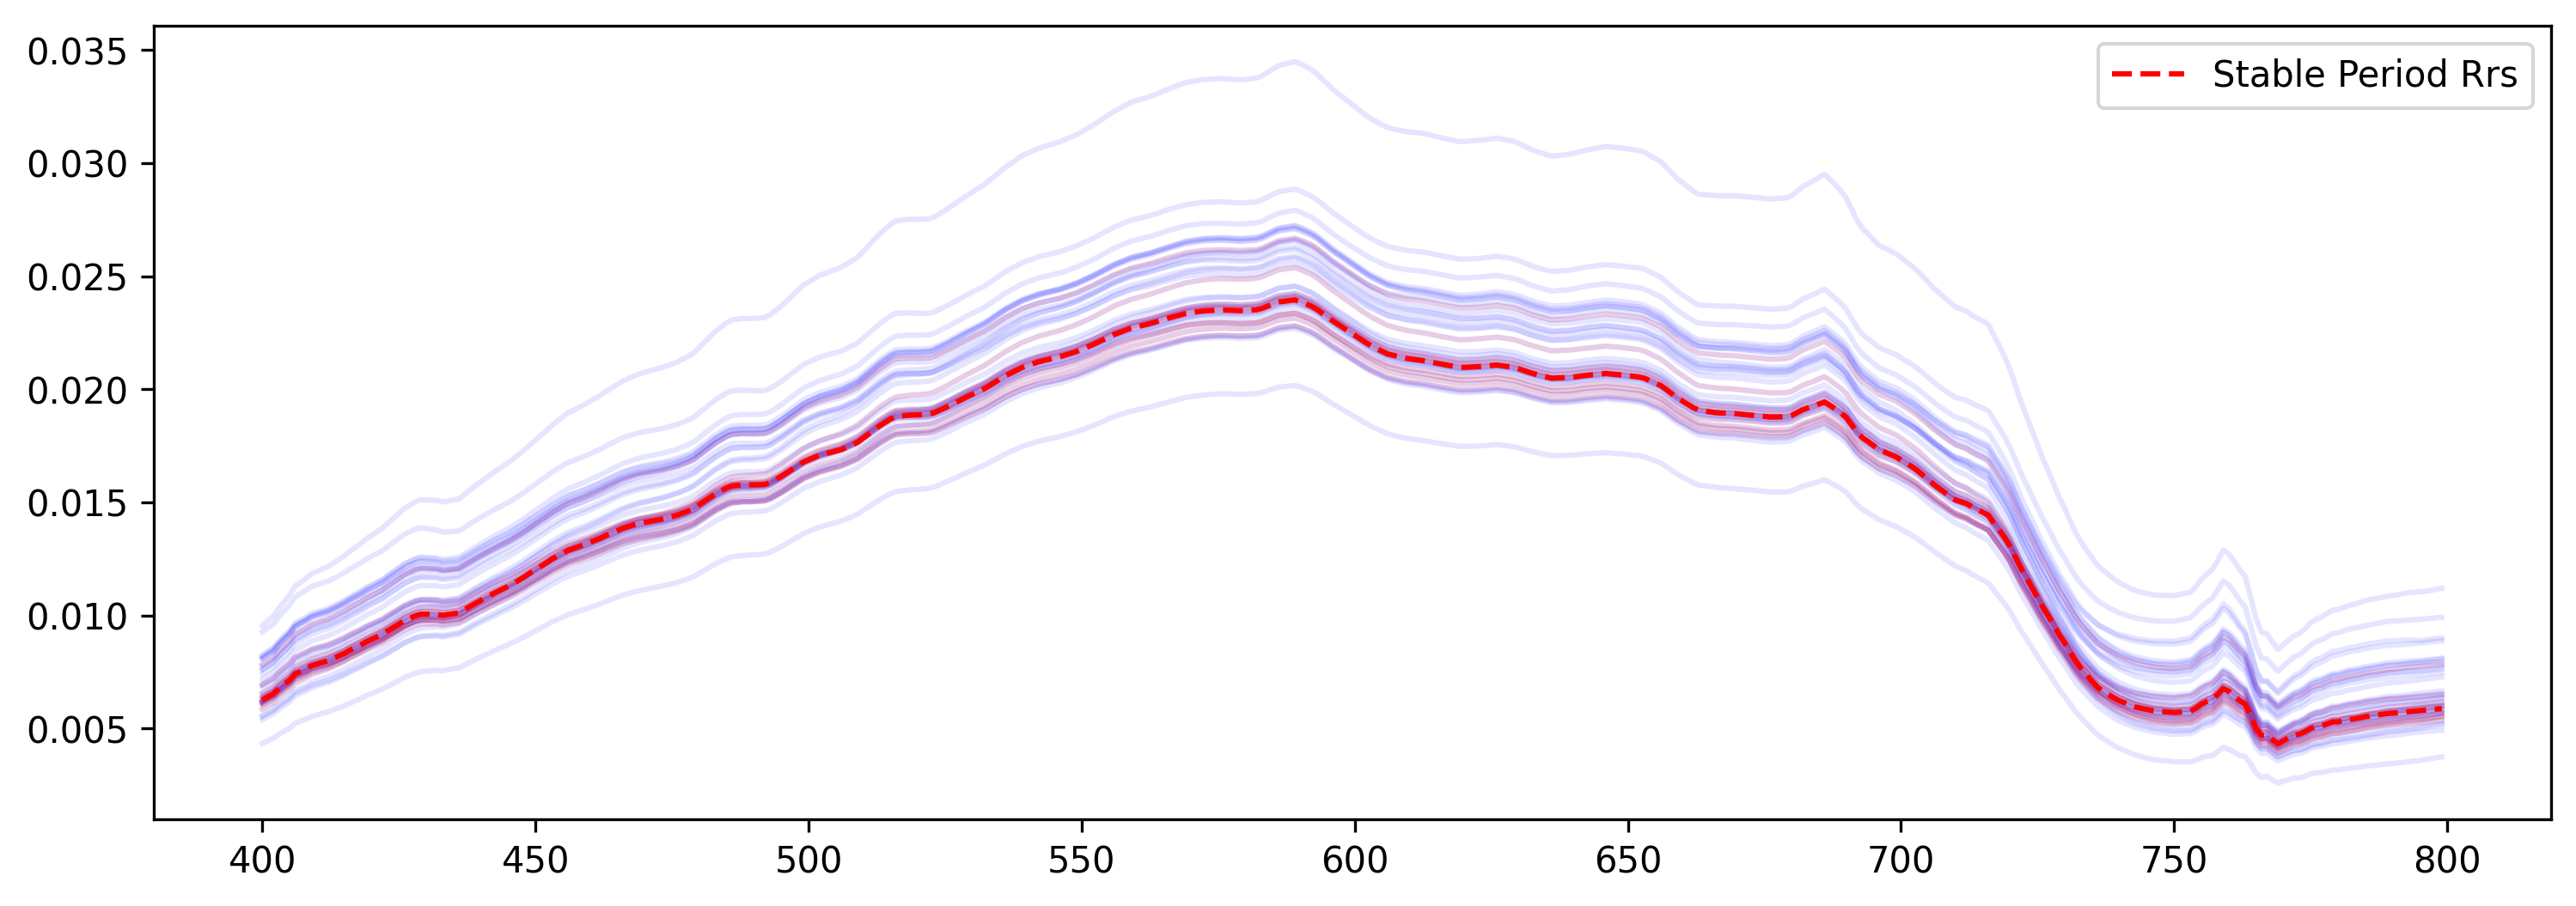

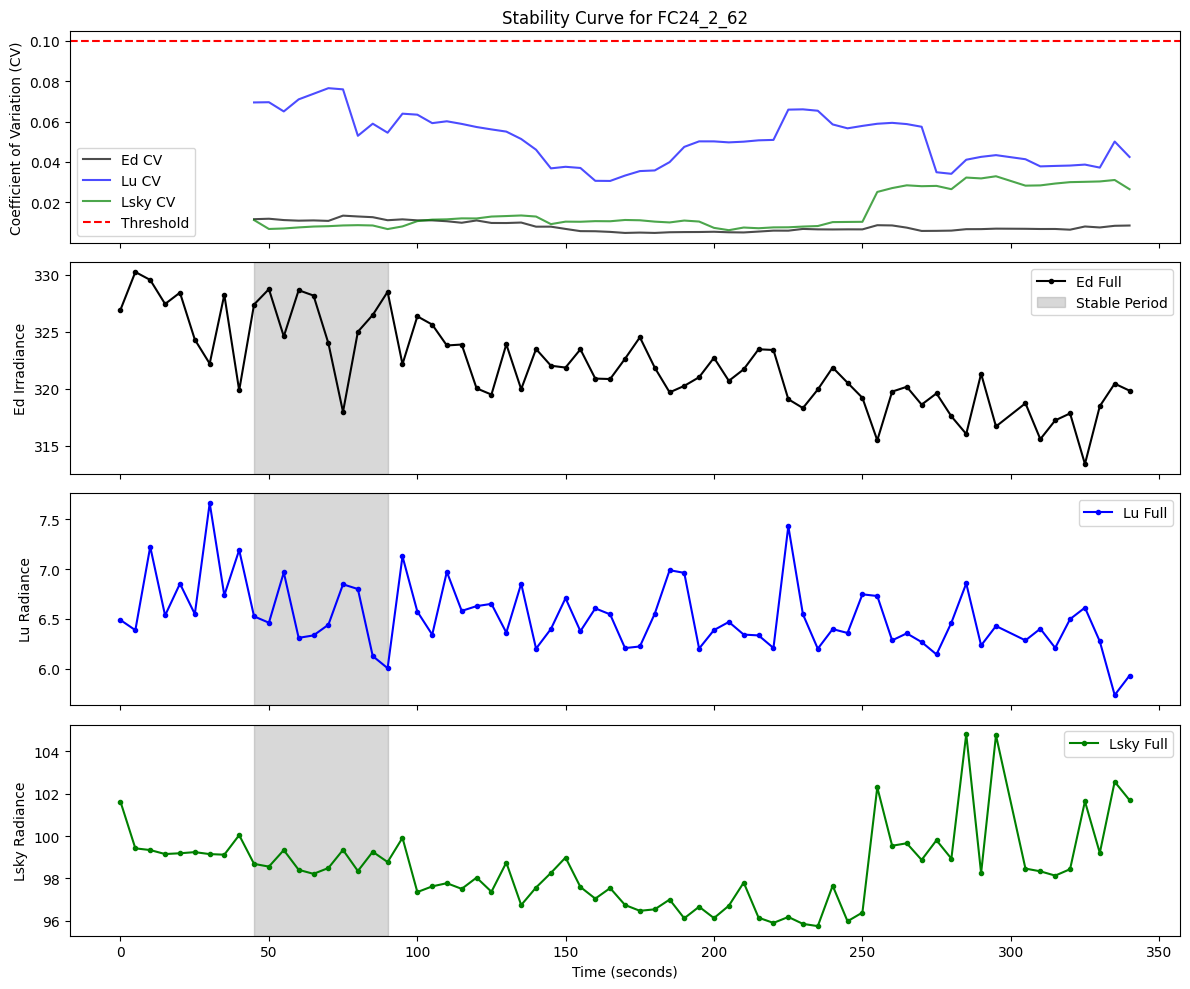

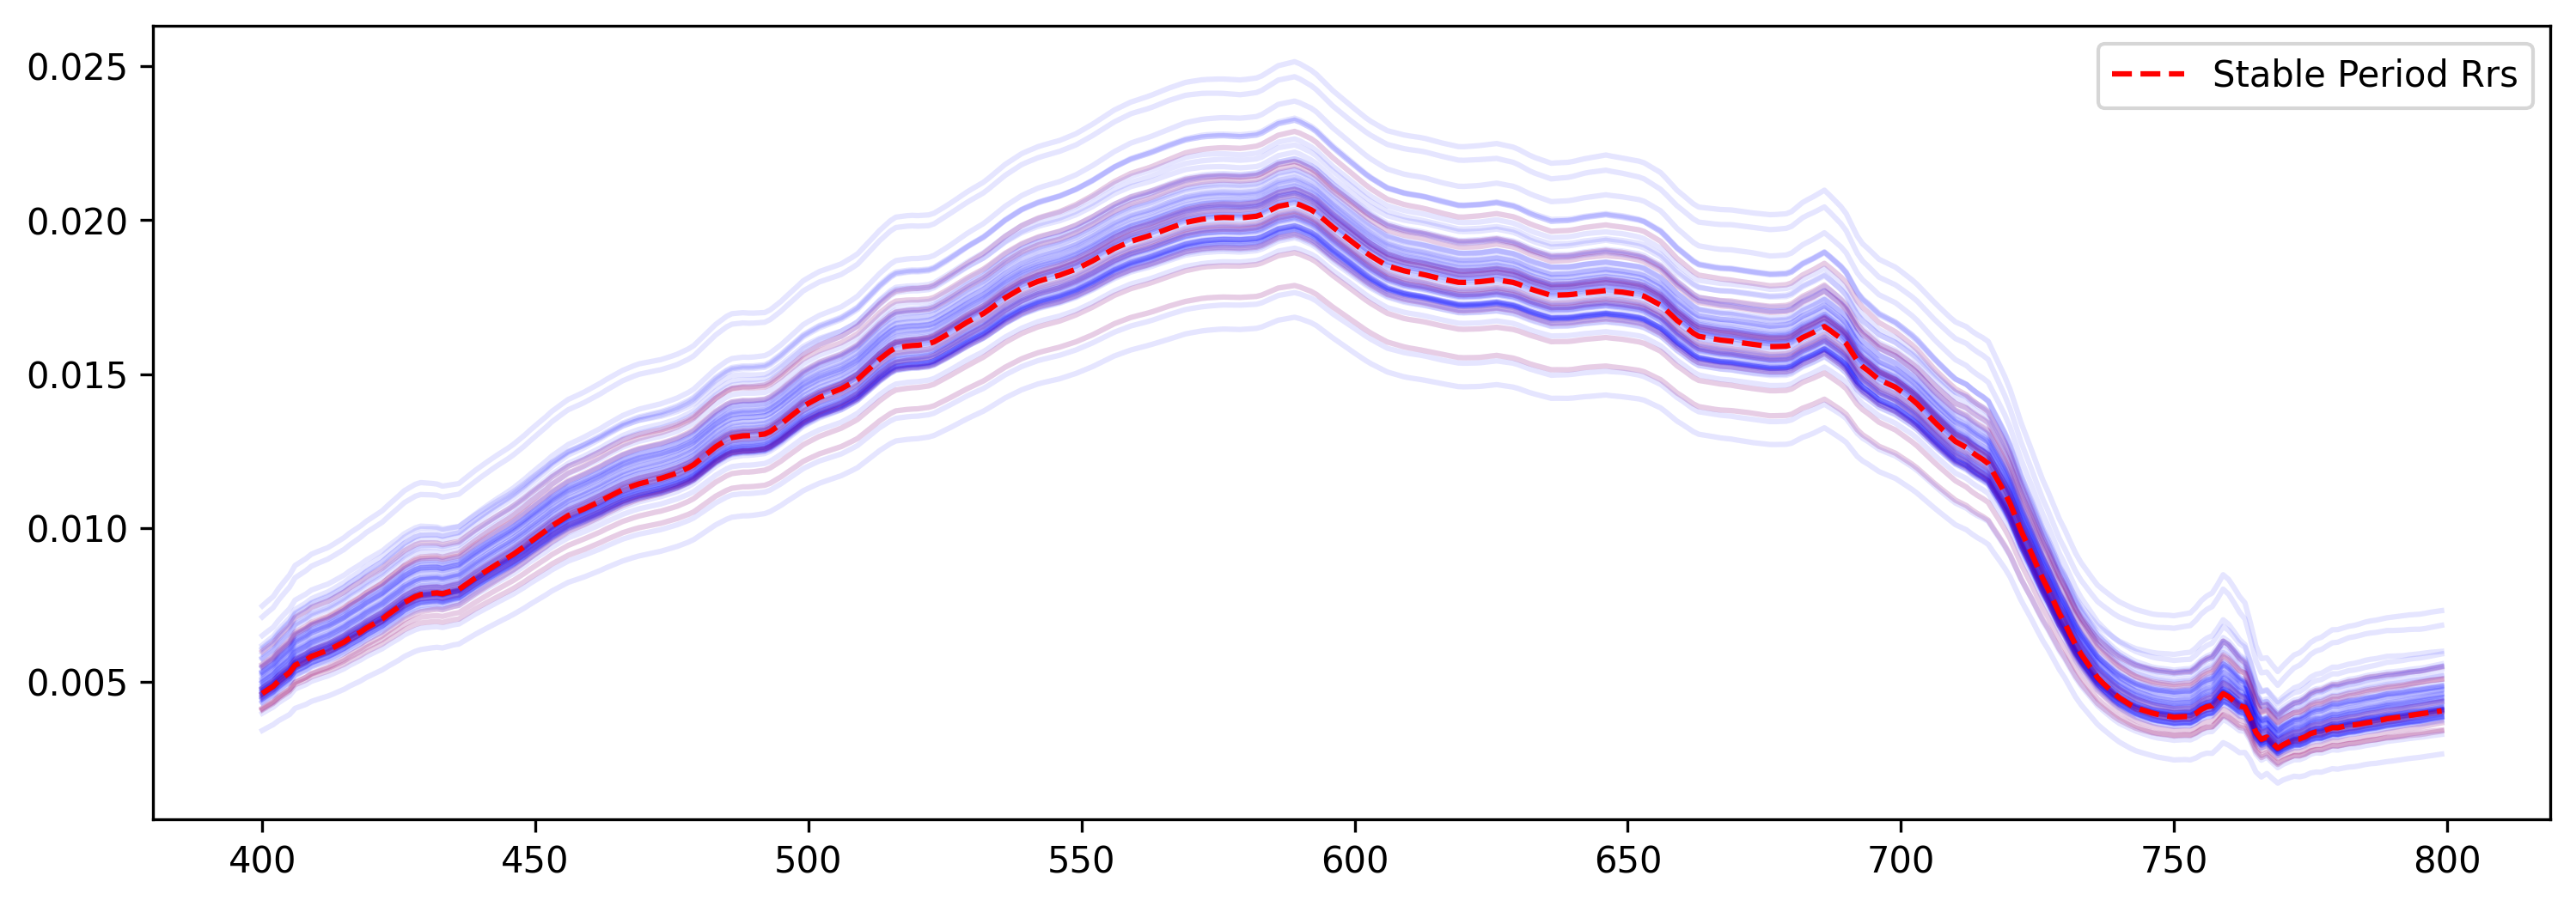

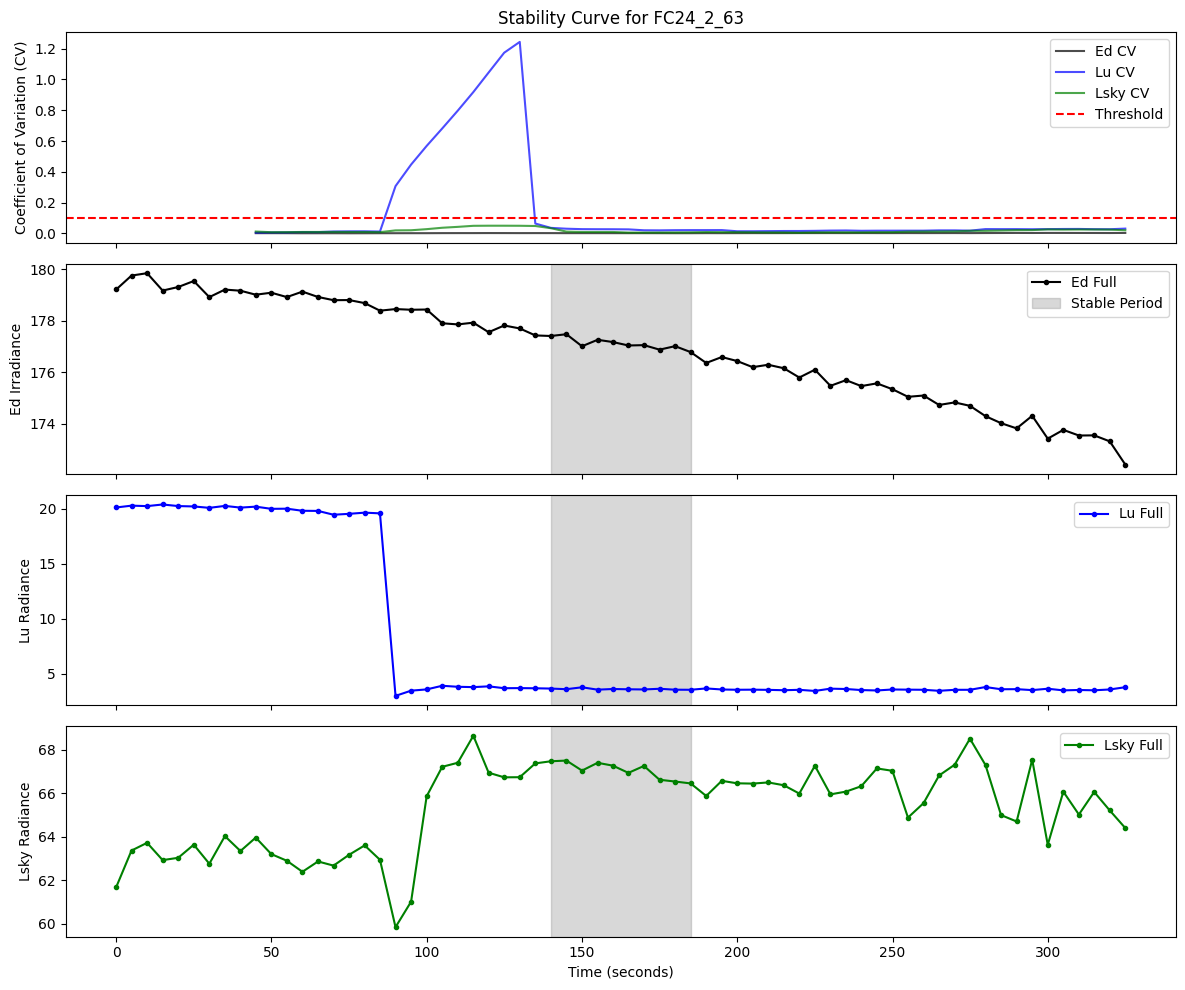

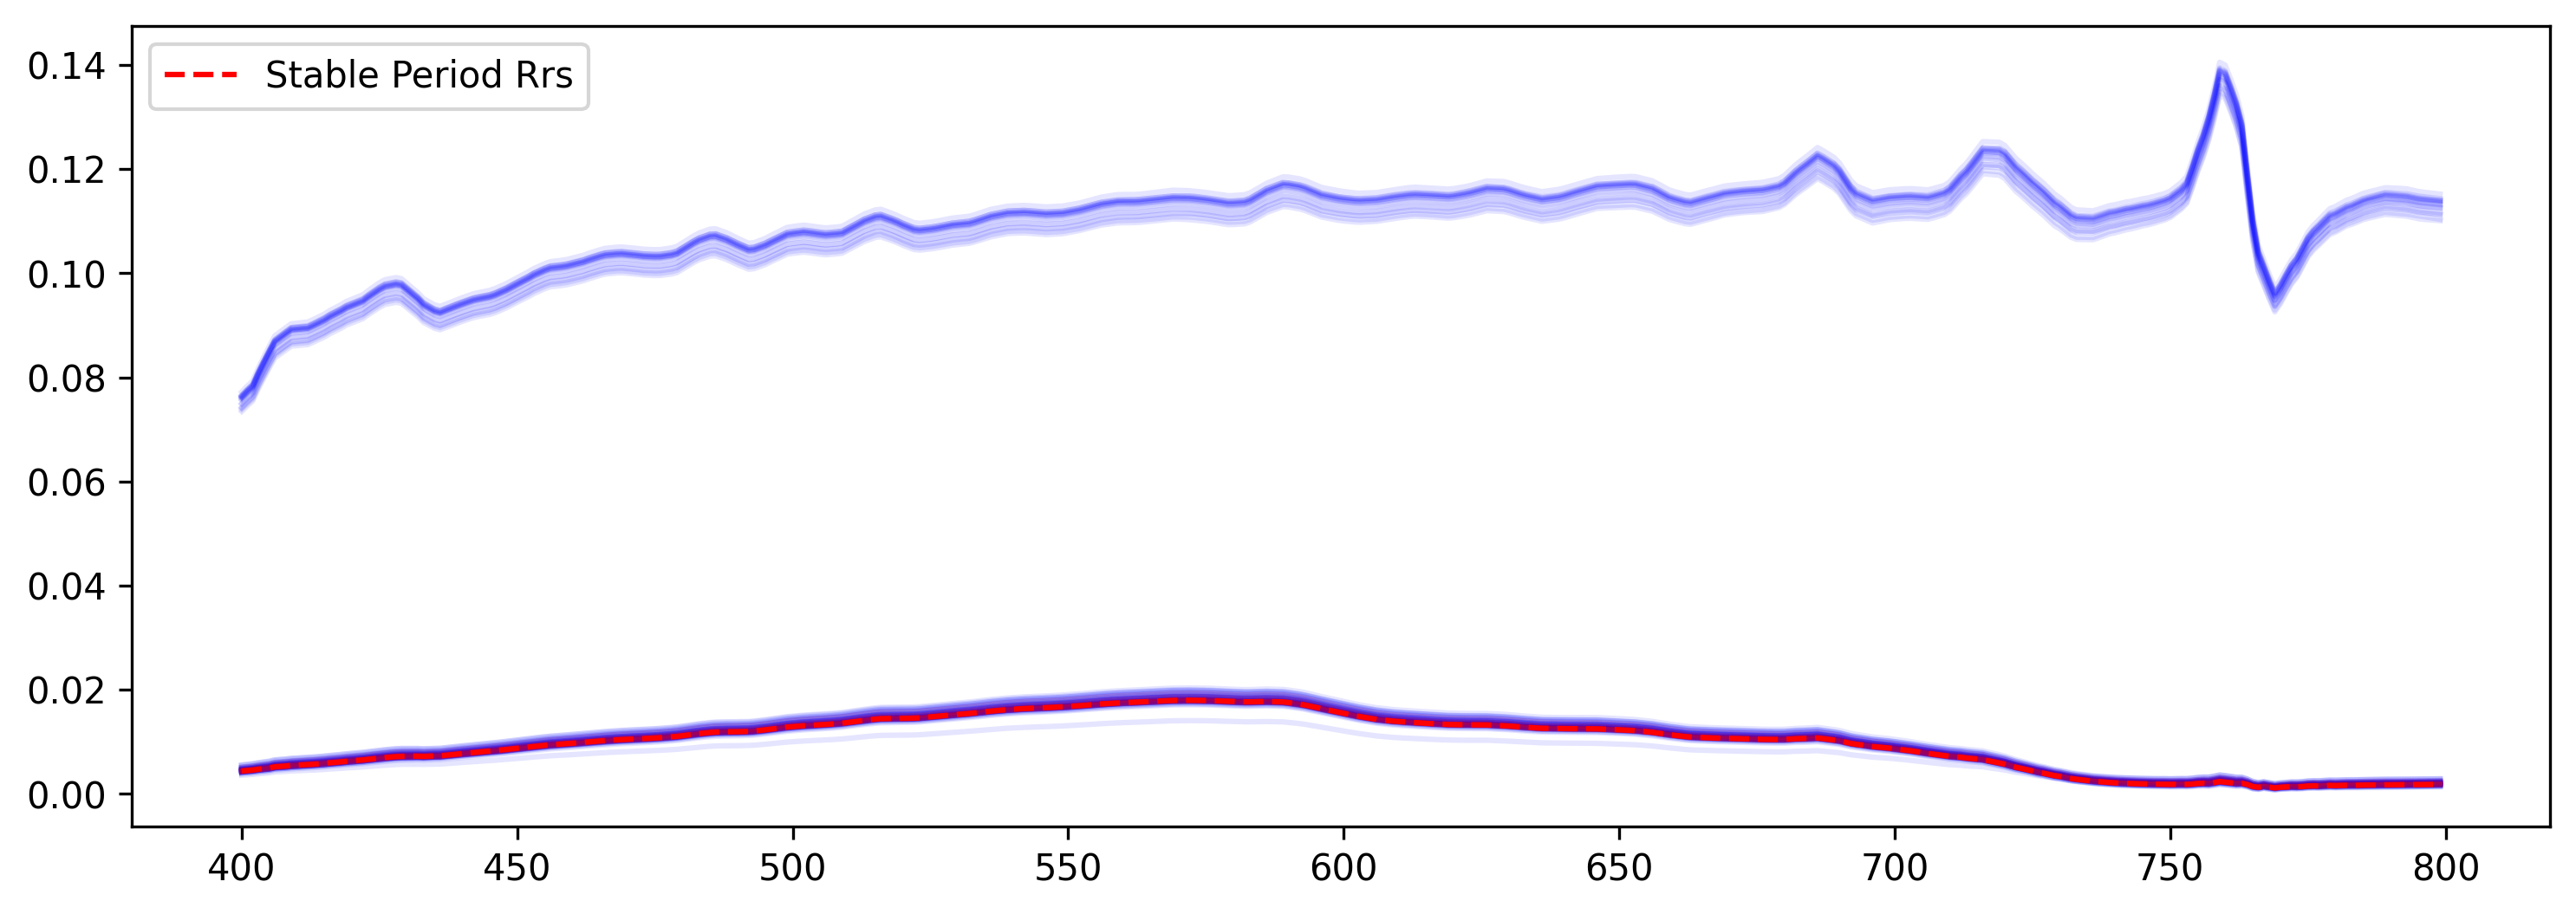

No stable period found. Forcing selection of the median time index.


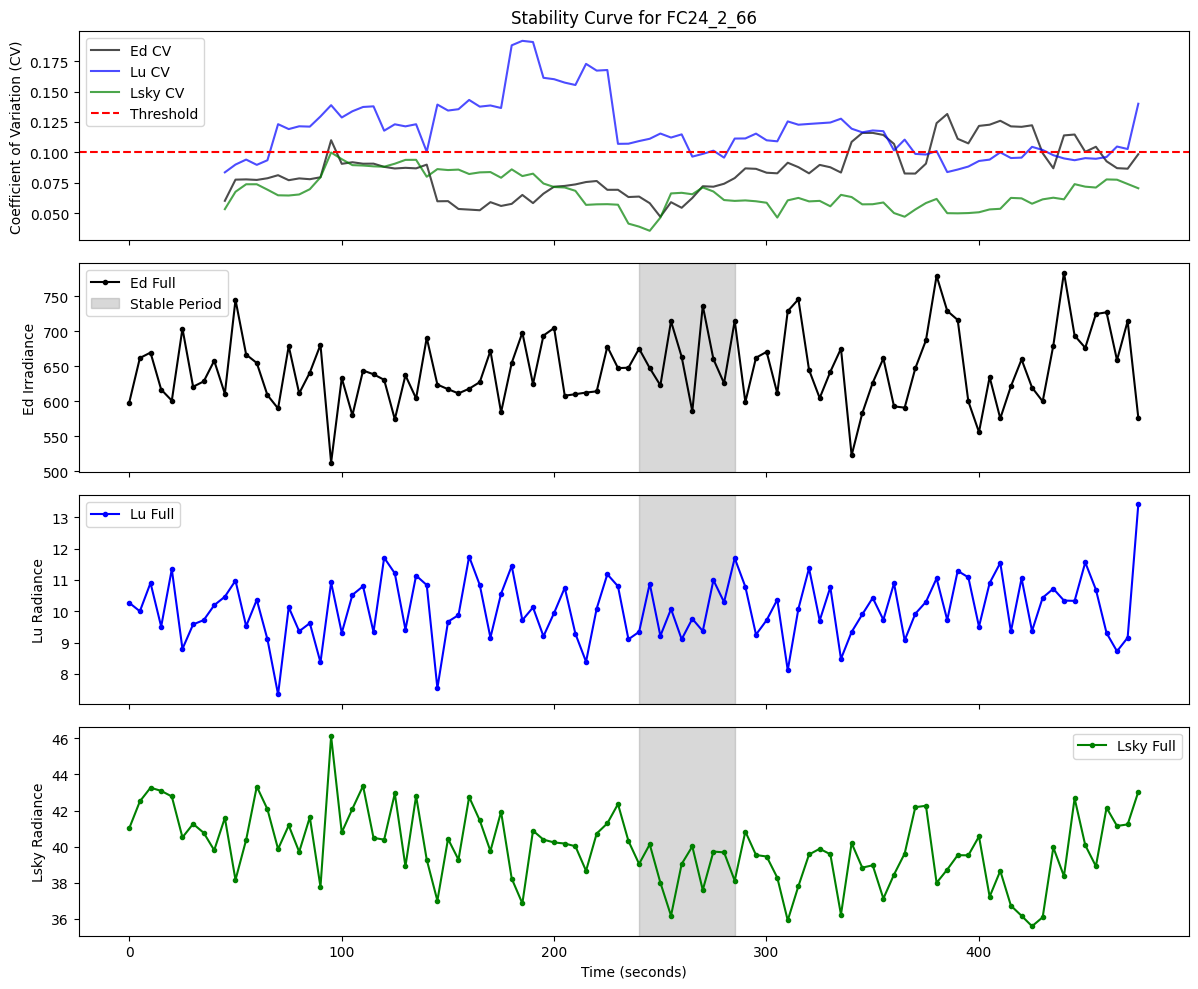

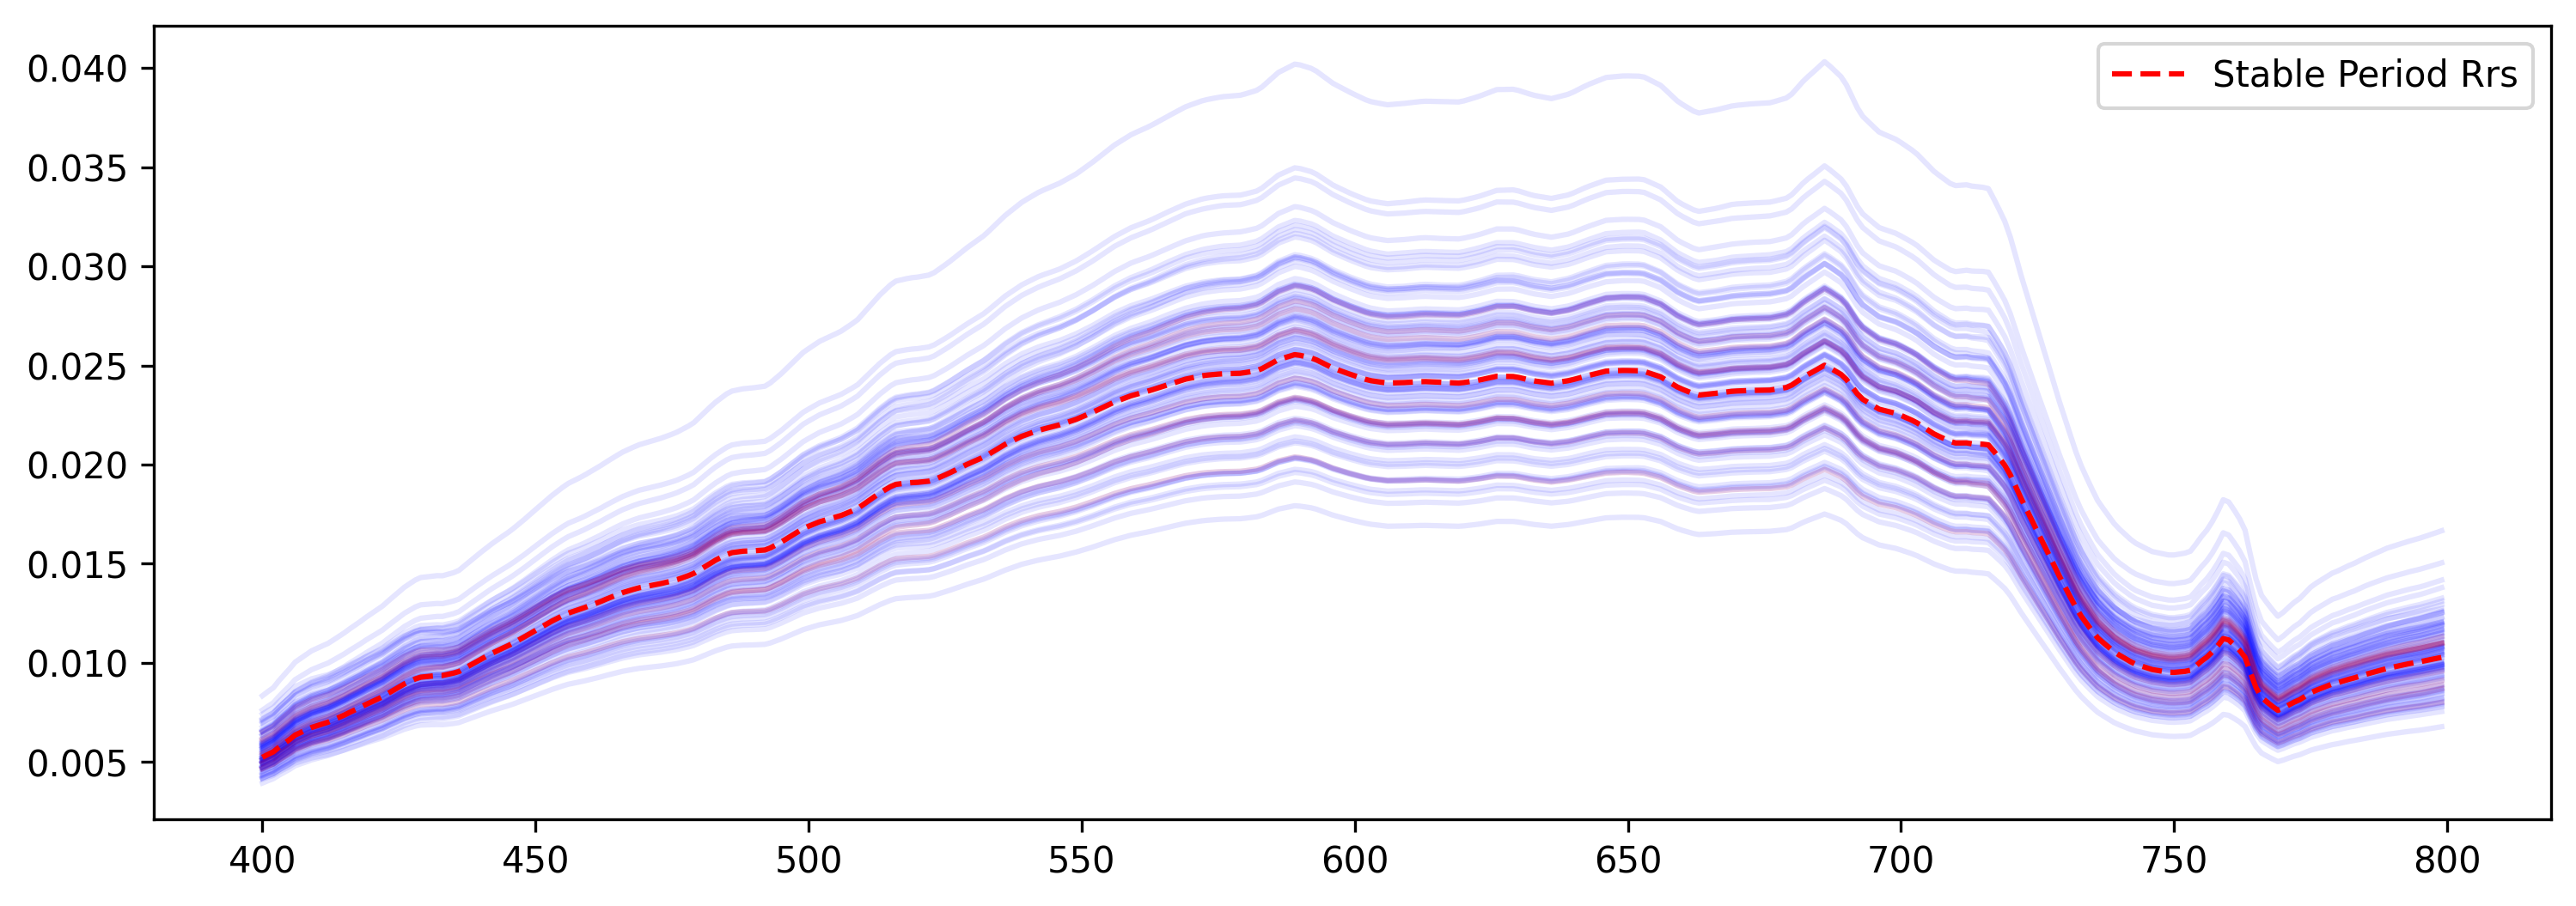

No stable period found. Forcing selection of the median time index.
Error processing station FC24_2_67: list index out of range
No stable period found. Forcing selection of the median time index.


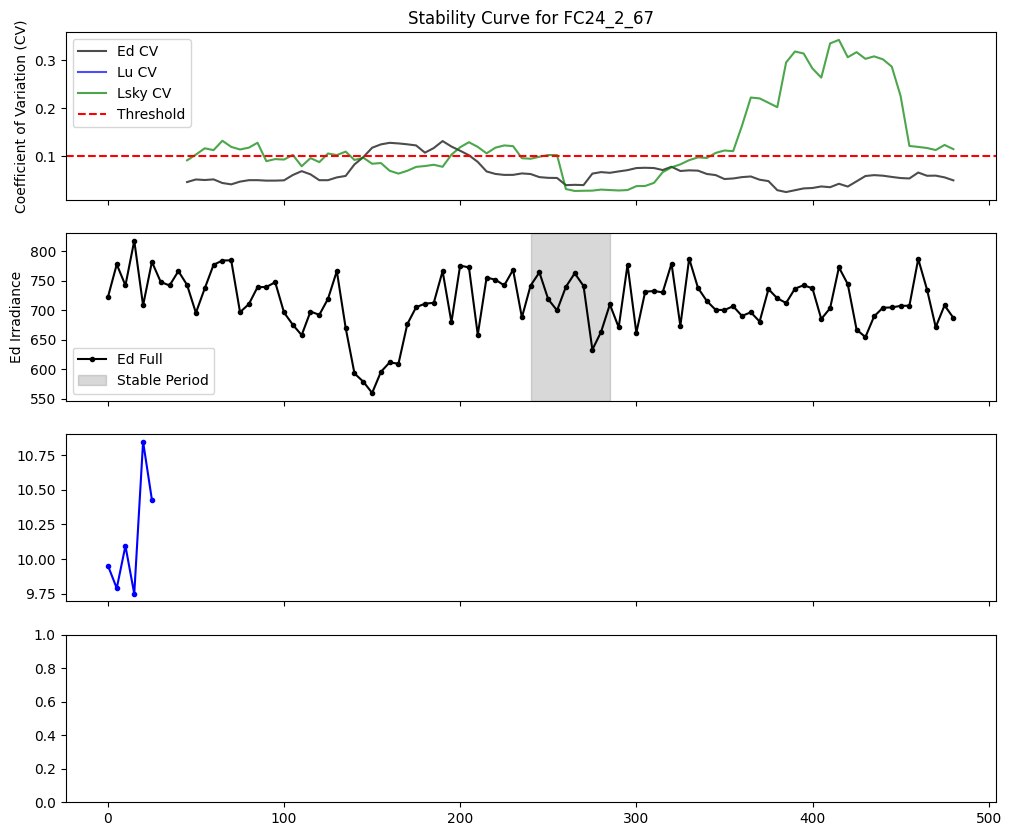

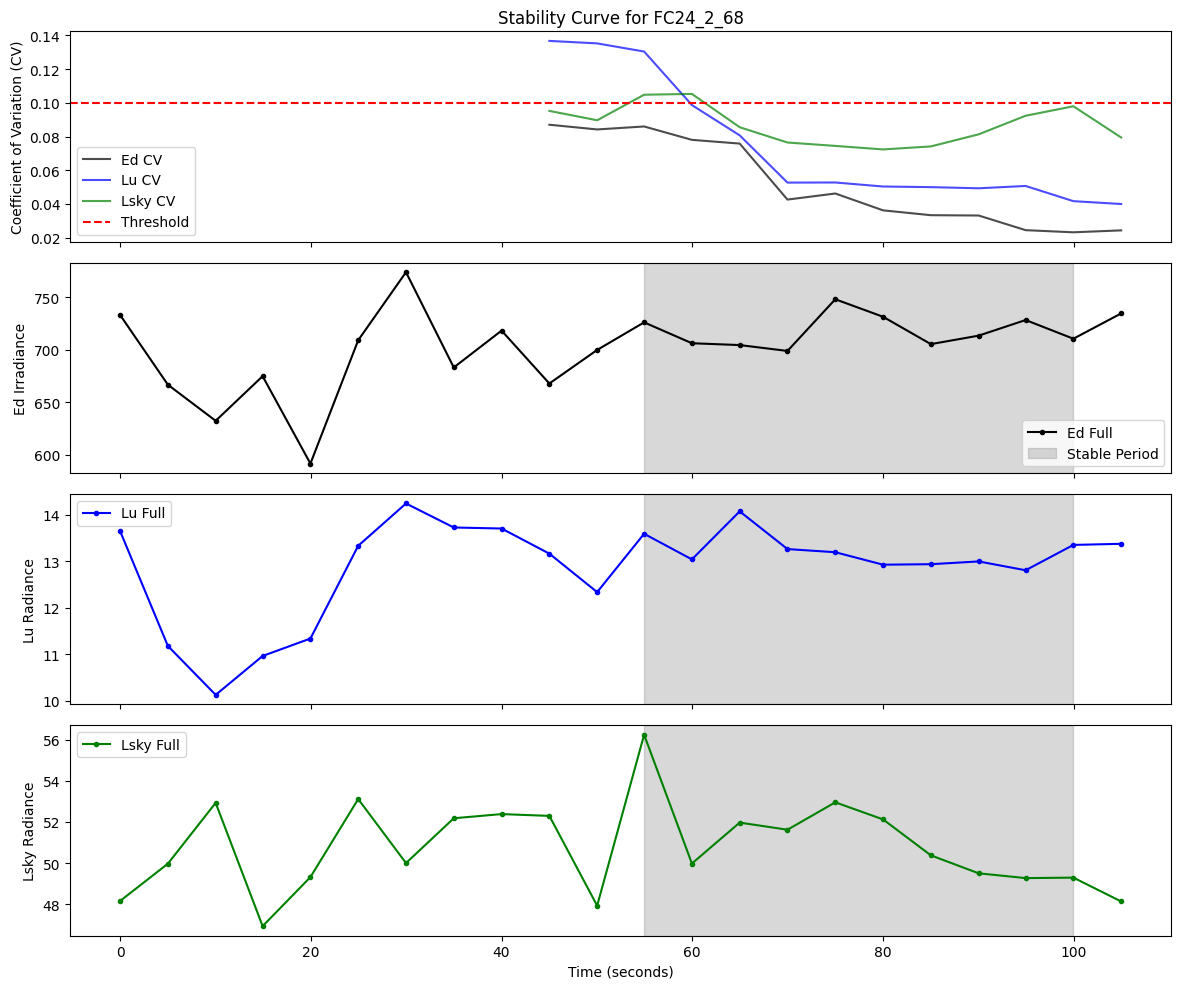

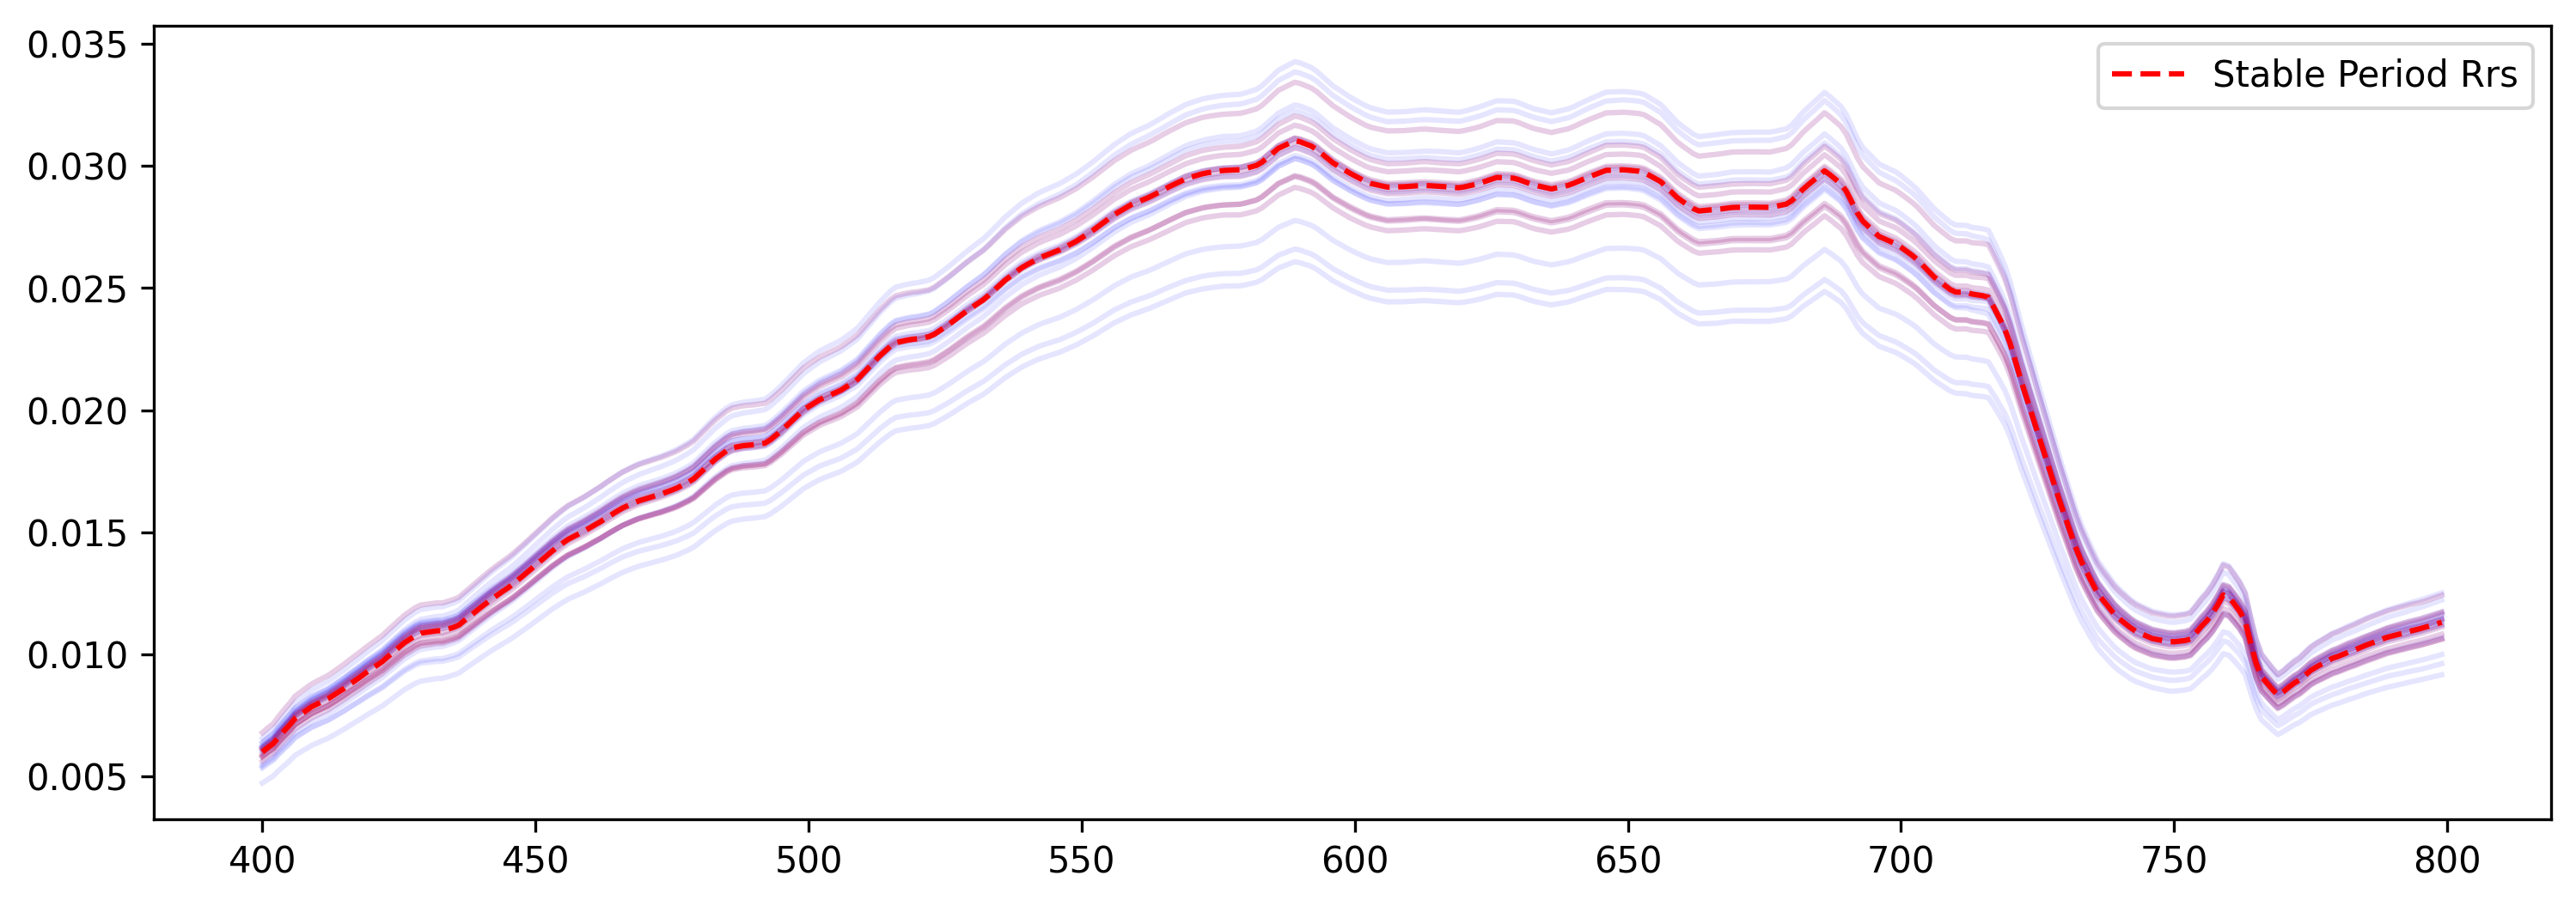

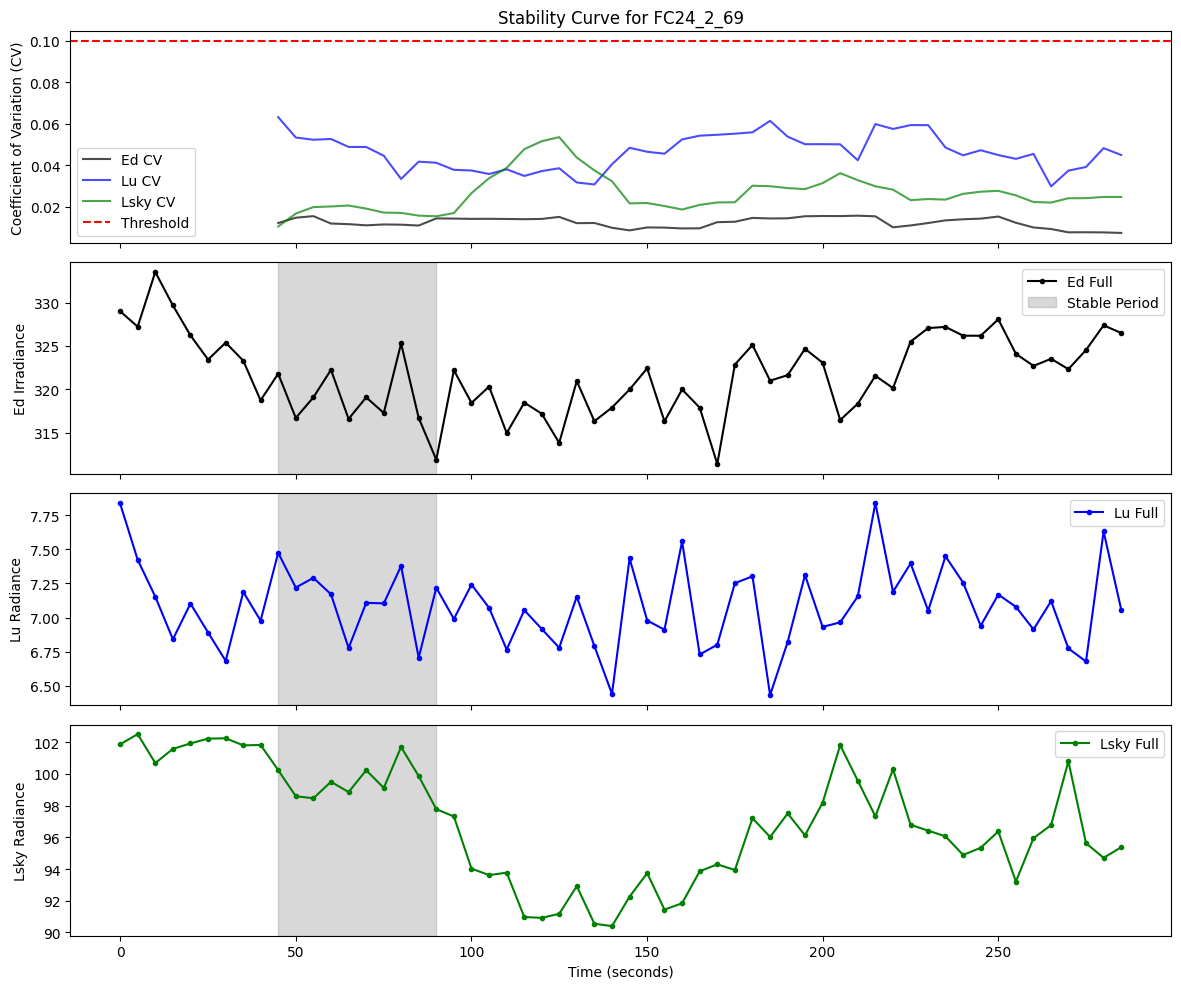

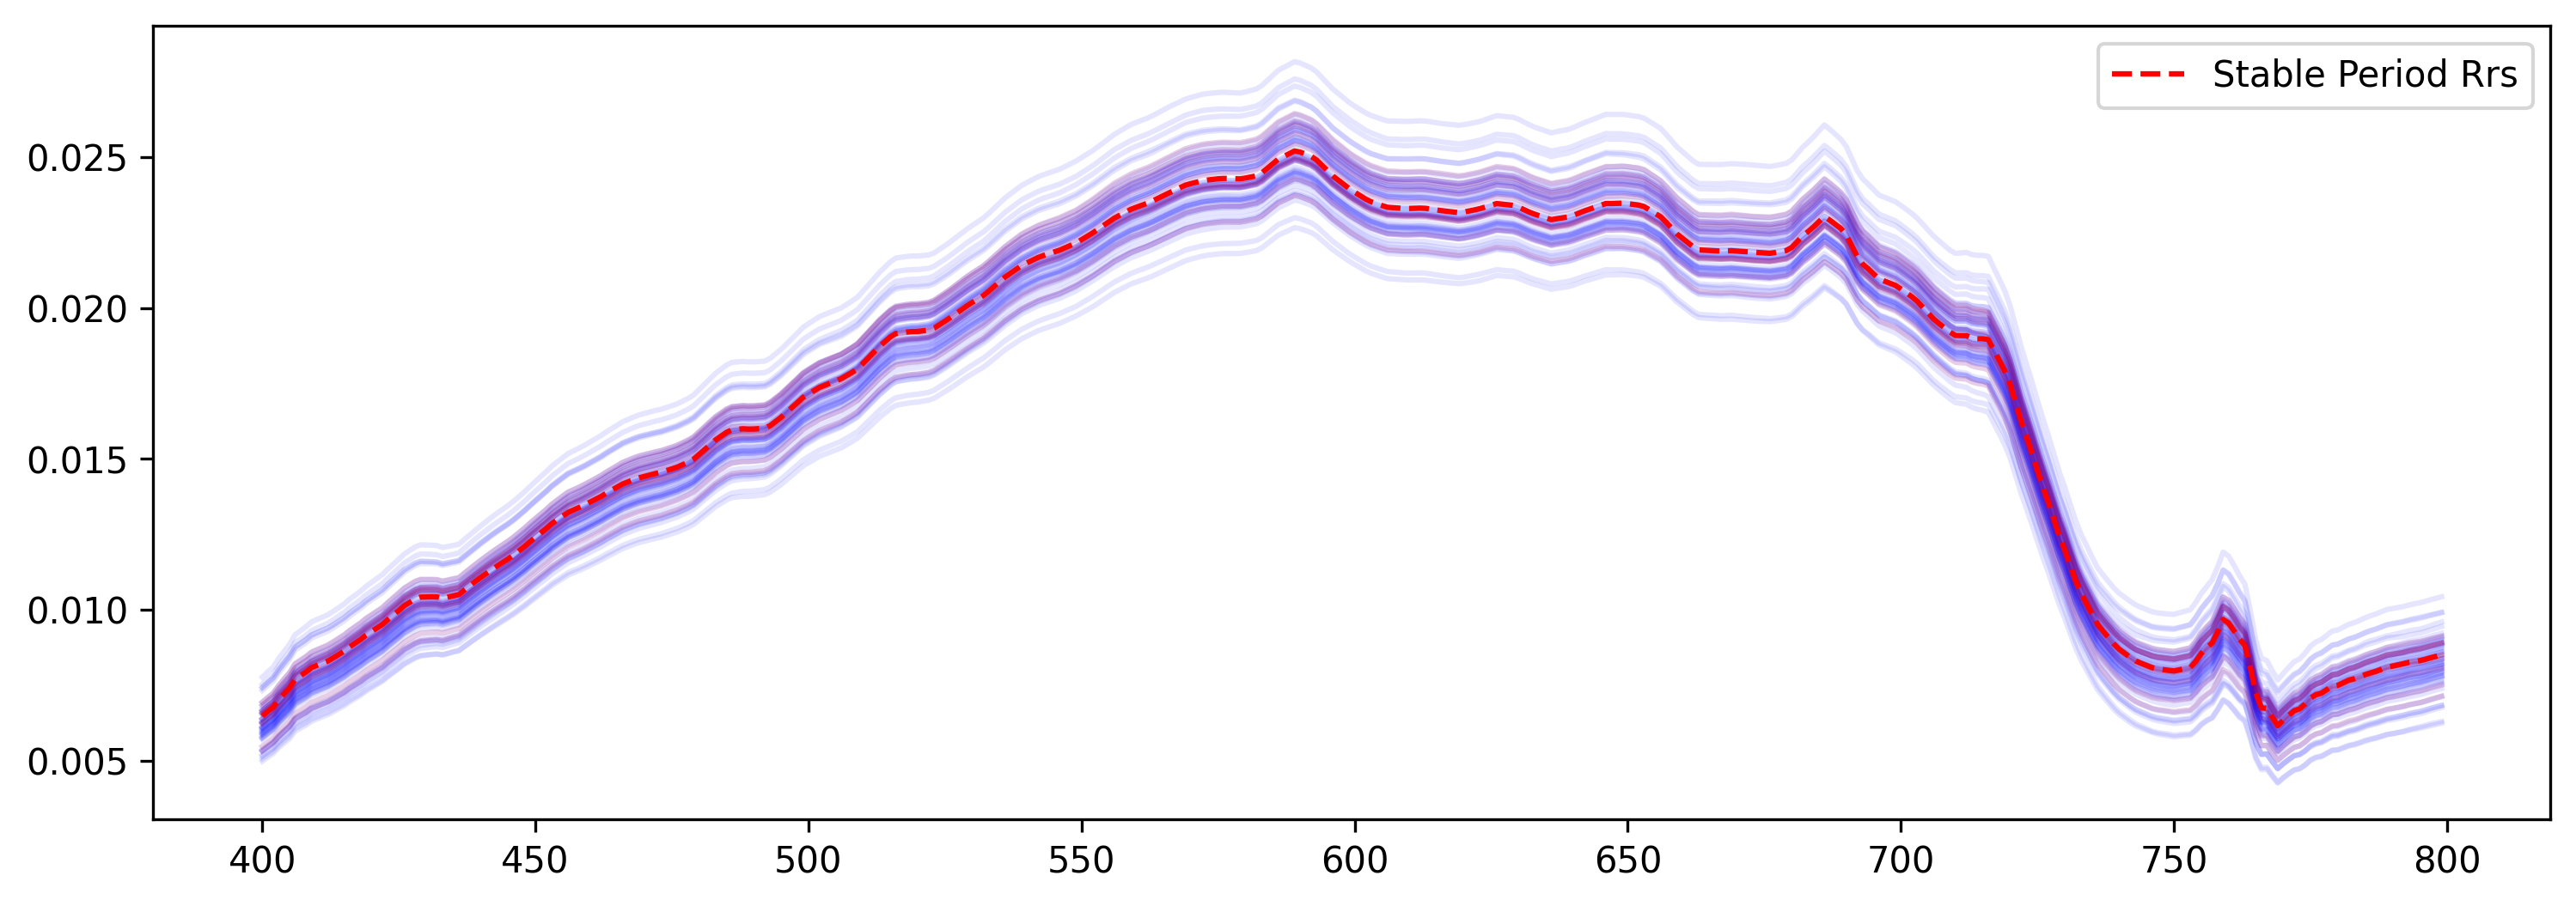

No stable period found. Forcing selection of the median time index.


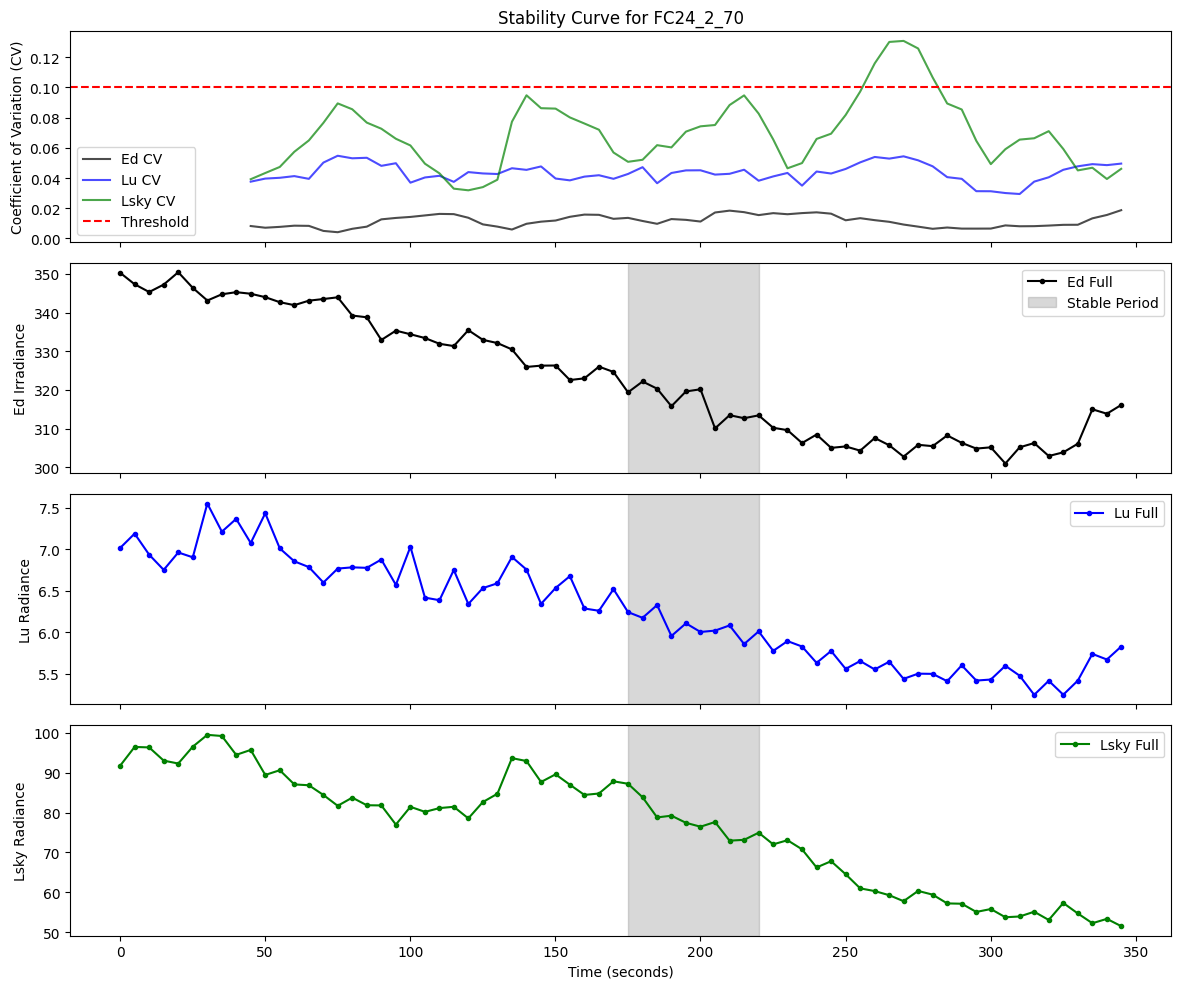

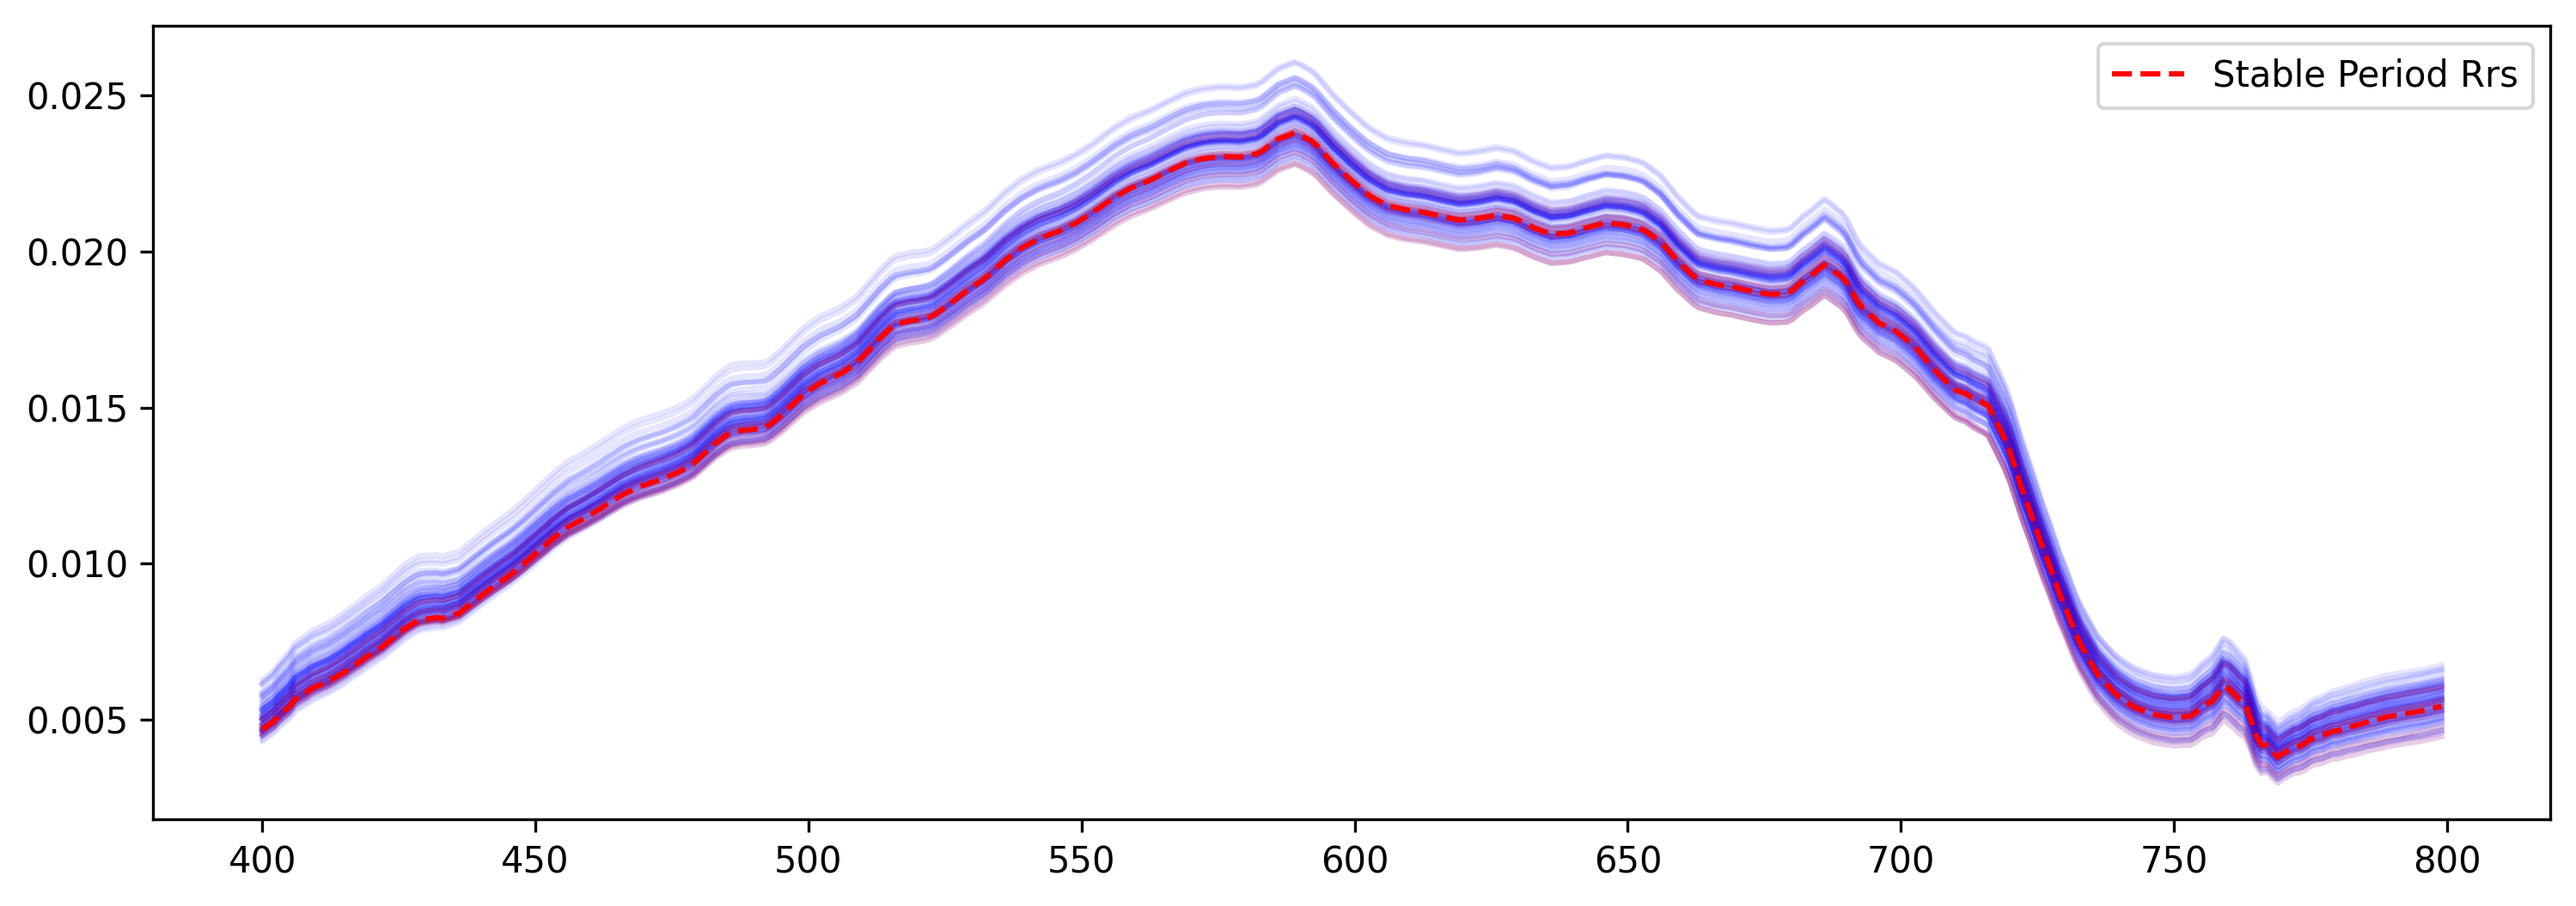

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime, timedelta

# Define function to convert Julian timestamp to datetime
def julian_to_datetime(julian):
    start_date = datetime(1970, 1, 1)
    
    if julian < 2440587.5:
        julian += 2440587.5  # Adjust the Julian date to a later valid range
    
    delta = timedelta(days=(julian - 2440587.5))
    
    try:
        return start_date + delta
    except OverflowError:
        return None

# Define function to find stable period with a forced fallback
def find_stable_period(cv_Ed, cv_Lu, cv_Lsky, min_length=10, threshold=0.1):
    combined_cv = cv_Ed + cv_Lu + cv_Lsky
    stable_periods = []

    for i in range(len(combined_cv) - min_length):
        if np.all(combined_cv[i:i+min_length] < threshold):
            stable_periods.append(i)
    
    if stable_periods:
        return stable_periods[0]
    else:
        print("No stable period found. Forcing selection of the median time index.")
        return len(combined_cv) // 2

# Main loop to process each station
for i, StationName in enumerate(df['StationName']):
    try:
        p_Lsky, p_Lu, p_Ed, p_Mobley_2 = df.loc[i, ['Lsky_raw_filepath', 'Lu_raw_filepath', 'Ed_raw_filepath', 'Rho_Mobley_1999_2']]

        if isinstance(p_Ed, str):  # Ensure file paths are valid strings
            # Load data
            Ed_data = pd.read_csv(p_Ed, skiprows=20, sep="\s+")
            Lu_data = pd.read_csv(p_Lu, skiprows=20, sep="\s+")
            Lsky_data = pd.read_csv(p_Lsky, skiprows=20, sep="\s+")
            
            # Extract wavelengths and measurements
            def extract_data(data):
                return np.array([row[1:-3] for _, row in data.iterrows()], dtype=np.float64), np.array(data.columns[4:], dtype=float), [idx[0] for idx in data.index]
            
            Ed_full, Wvls_Ed, Time_Ed = extract_data(Ed_data)
            Lu_full, Wvls_Lu, Time_Lu = extract_data(Lu_data)
            Lsky_full, Wvls_Lsky, Time_Lsky = extract_data(Lsky_data)
            
            # Convert timestamps to datetime
            Time_Ed = [julian_to_datetime(ts) for ts in Time_Ed]
            Time_Lu = [julian_to_datetime(ts) for ts in Time_Lu]
            Time_Lsky = [julian_to_datetime(ts) for ts in Time_Lsky]

            # Convert datetime to seconds since start
            seconds_since_start_Ed = [(dt - Time_Ed[0]).total_seconds() for dt in Time_Ed]
            seconds_since_start_Lu = [(dt - Time_Lu[0]).total_seconds() for dt in Time_Lu]
            seconds_since_start_Lsky = [(dt - Time_Lsky[0]).total_seconds() for dt in Time_Lsky]

            # Compute stability using coefficient of variation (CV)
            def compute_stability(data, window_size=10):
                rolling_std = pd.DataFrame(data).rolling(window=window_size, axis=0).std()
                rolling_mean = pd.DataFrame(data).rolling(window=window_size, axis=0).mean()
                return (rolling_std / rolling_mean).mean(axis=1)
            
            cv_Ed = compute_stability(Ed_full)
            cv_Lu = compute_stability(Lu_full)
            cv_Lsky = compute_stability(Lsky_full)
            
            # Find most stable period or force selection
            stable_period = find_stable_period(cv_Ed, cv_Lu, cv_Lsky, min_length=10, threshold=0.1)

            stable_range = slice(stable_period, min(stable_period + 10, len(Ed_full)))

            Ed_stable, Lu_stable, Lsky_stable = Ed_full[stable_range], Lu_full[stable_range], Lsky_full[stable_range]

            # Plot original time series and stability curve
            fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
            
            axs[0].plot(seconds_since_start_Ed, cv_Ed, label="Ed CV", color='black', linestyle='-', alpha=0.7)
            axs[0].plot(seconds_since_start_Lu, cv_Lu, label="Lu CV", color='blue', linestyle='-', alpha=0.7)
            axs[0].plot(seconds_since_start_Lsky, cv_Lsky, label="Lsky CV", color='green', linestyle='-', alpha=0.7)
            axs[0].axhline(y=0.1, color='red', linestyle='--', label="Threshold")
            axs[0].set_ylabel("Coefficient of Variation (CV)")
            axs[0].set_title(f"Stability Curve for {StationName}")
            axs[0].legend()

            axs[1].plot(seconds_since_start_Ed, Ed_full[:, 50], "k.-", label='Ed Full')
            axs[1].axvspan(seconds_since_start_Ed[stable_period], seconds_since_start_Ed[min(stable_period + 9, len(seconds_since_start_Ed) - 1)], color='gray', alpha=0.3, label='Stable Period')
            axs[1].set_ylabel("Ed Irradiance")
            axs[1].legend()
            
            axs[2].plot(seconds_since_start_Lu, Lu_full[:, 50], "b.-", label='Lu Full')
            axs[2].axvspan(seconds_since_start_Lu[stable_period], seconds_since_start_Lu[min(stable_period + 9, len(seconds_since_start_Lu) - 1)], color='gray', alpha=0.3)
            axs[2].set_ylabel("Lu Radiance")
            axs[2].legend()
            
            axs[3].plot(seconds_since_start_Lsky, Lsky_full[:, 50], "g.-", label='Lsky Full')
            axs[3].axvspan(seconds_since_start_Lsky[stable_period], seconds_since_start_Lsky[min(stable_period + 9, len(seconds_since_start_Lsky) - 1)], color='gray', alpha=0.3)
            axs[3].set_ylabel("Lsky Radiance")
            axs[3].set_xlabel("Time (seconds)")
            axs[3].legend()

            plt.tight_layout()
            plt.show()

            if len(Lsky_full) == len(Lu_full) == len(Ed_full):
                new_wavelengths = np.arange(400, 800, 1)

                def process_rrs(Ed, Lu, Lsky):
                    Rrs_list = []
                    for j in range(len(Ed)):
                        def interpolate(wavelengths, values):
                            return interp1d(wavelengths, values, kind='linear', fill_value="extrapolate")(new_wavelengths)
                        
                        Lsky_interp = interpolate(Wvls_Lsky, Lsky[j])
                        Lu_interp = interpolate(Wvls_Lu, Lu[j])
                        Ed_interp = interpolate(Wvls_Ed, Ed[j])
                        
                        Rrs = (Lu_interp - p_Mobley_2 * Lsky_interp) / Ed_interp
                        Rrs_list.append(Rrs)
                    
                    return np.array(Rrs_list)
                
                Rrs_collector_full = process_rrs(Ed_full, Lu_full, Lsky_full)
                Rrs_collector_stable = process_rrs(Ed_stable, Lu_stable, Lsky_stable)
                
                fig, ax1 = plt.subplots(figsize=(12, 4), dpi=300)
        
                for rrs in Rrs_collector_full:
                    ax1.plot(new_wavelengths, rrs, 'b-', alpha=0.1)
                
                for rrs in Rrs_collector_stable:
                    ax1.plot(new_wavelengths, rrs, 'r-', alpha=0.1)
                
                ax1.plot(new_wavelengths, np.nanmedian(Rrs_collector_stable, axis=0), "r--", label='Stable Period Rrs')
                
                ax1.legend()
                plt.show()

            else:
                print(f'Sensors have different numbers of measurements for {StationName}')

    except Exception as e:
        print(f"Error processing station {StationName}: {e}")
        continue


